# ISEAR and NRC Labels

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy
import re

In [2]:
# from py_isear import 
from py_isear.isear_loader import IsearLoader
attributes = ['EMOT','SIT']
target = ['TROPHO','TEMPER']
loader = IsearLoader(attributes, target, True)
data = loader.load_isear('py_isear/isear.csv')
# data.get_data() # returns attributes
# data.get_target() # returns target
# data.get_freetext_content() # returns the text content of the database

In [3]:
# turn attributes to list
attributes = data.get_data()
attributes = sum(attributes,[])
# attributes

In [4]:
isear_text = list(data.get_freetext_content())
# isear_text

In [5]:
# create df from attribute and the data;
df = pd.DataFrame({'isear_text':isear_text,'isear_label':attributes})

In [6]:
df = df.set_index('isear_text')

In [7]:
d = {1:'joy',2:'fear',3:'anger',4:'sadness',5:'disgust',6:'shame',7:'guilt'}

In [8]:
df = df.replace({"isear_label": d})

In [9]:
df.head()

,isear_label
isear_text,
"During the period of falling in love, each time that we met and á especially when we had not met for a long time.",joy
When I was involved in a traffic accident.,fear
"When I was driving home after several days of hard work, there á was a motorist ahead of me who was driving at 50 km/hour and á refused, despite his low speeed to let me overtake.",anger
When I lost the person who meant the most to me.,sadness
"The time I knocked a deer down - the sight of the animal's á injuries and helplessness. The realization that the animal was á so badly hurt that it had to be put down, and when the animal á screamed at the moment of death.",disgust


In [10]:
import pandas as pd
from nltk import word_tokenize

filepath = ('NRC-Emotion-Lexicon/'
                'NRC-Emotion-Lexicon-v0.92/'
                'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')

emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')


emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()

# emolex_df = emolex_df.drop('positive','negative')

emolex_words = emolex_words.drop(['positive','negative'],axis=1)
emotions = emolex_words.columns.drop('word')
emo_df = pd.DataFrame(0, index=df.index, columns=emotions)

In [11]:
emo_df

emotion,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
isear_text,,,,,,,,
"During the period of falling in love, each time that we met and á especially when we had not met for a long time.",0,0,0,0,0,0,0,0
When I was involved in a traffic accident.,0,0,0,0,0,0,0,0
"When I was driving home after several days of hard work, there á was a motorist ahead of me who was driving at 50 km/hour and á refused, despite his low speeed to let me overtake.",0,0,0,0,0,0,0,0
When I lost the person who meant the most to me.,0,0,0,0,0,0,0,0
"The time I knocked a deer down - the sight of the animal's á injuries and helplessness. The realization that the animal was á so badly hurt that it had to be put down, and when the animal á screamed at the moment of death.",0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
Two years back someone invited me to be the tutor of her á grand-daughter. The grand-daughter asked me some questions in á mathematics so I taught her. However she did not listen to me á and this made me feel unhappy. The second year it was the same. á When I entered university the girl's parents suggested that I be á employed as their daghters tutor. They told me that at university á there was no homework and I would have a lot of time so they á made a time-table for me which required me to be the tutor five á days a week. They did not respect me and anyway I had another á child to teach.,0,0,0,0,0,0,0,0
I had taken the responsibility to do something and I had á prepared for it. However I failed because of my timidity. After á three attempts I still could not adapt to the atmosphere and á failed as before. I felt imcompetent and felt that the others á would think that I had not prepared for it.,0,0,0,0,0,0,0,0
I was at home and I heard a loud sound of spitting outside the á door. I thought that one of my family members would step on the spit á and bring the germs in the house.,0,0,0,0,0,0,0,0


In [12]:
# count whether a token appears in the index and then count 
# must remove stopwords and tokenize the isear_text

# reference to nltk

# remove puncutations
# tokenize
# remove stopwords
import spacy


def isear_nrc_loop():
    new_df = df.copy()
    emo_df2 = emo_df.copy()
    nlp = spacy.load("en_core_web_lg")
    for i, row in new_df.iterrows():
        doc = nlp(i)
        document = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
        for word in document:
            emo_score = emolex_words[emolex_words.word == word]
            if not emo_score.empty:
                for emotion in list(emotions):
                    emo_df2.at[i, emotion] += emo_score[emotion].values # add the score under the emotion cat
    nrc_label_df = emo_df2.idxmax(axis=1).to_frame('nrc_label')
    final = pd.concat([new_df, nrc_label_df], axis=1)
    return final

In [13]:
output = isear_nrc_loop()
output.head()

,isear_label,nrc_label
isear_text,,
"During the period of falling in love, each time that we met and á especially when we had not met for a long time.",joy,anticipation
When I was involved in a traffic accident.,fear,fear
"When I was driving home after several days of hard work, there á was a motorist ahead of me who was driving at 50 km/hour and á refused, despite his low speeed to let me overtake.",anger,sadness
When I lost the person who meant the most to me.,sadness,sadness
"The time I knocked a deer down - the sight of the animal's á injuries and helplessness. The realization that the animal was á so badly hurt that it had to be put down, and when the animal á screamed at the moment of death.",disgust,sadness


In [14]:
output.shape

(7666, 2)

# Create Tokens

In [23]:
nlp = spacy.load("en_core_web_lg")

def tokenize_func(text):
    doc = nlp(text)
    first_words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    words = [w for w in first_words if len(w) > 2]
    words = [w for w in words if w != 'http'] # remove http
    return words

In [24]:
output['isear_text'] = output.index.to_series()
output['tokens'] = output['isear_text'].apply(tokenize_func)

# Get DepecheMood Labels

In [29]:
def read_depechemood():
    '''
    reads depechemood lexicon that has scores for 8 ranges of mood for 37 terms
    ----
    returns

    a panda dataframe with terms as index, emotion categories as columns, scores as rows
    '''
    import pandas as pd
    dm_url = "https://raw.githubusercontent.com/marcoguerini/DepecheMood/master/DepecheMood%2B%2B/DepecheMood_english_token_full.tsv"
    depechemood = pd.read_csv(dm_url, sep='\t', index_col=0)
    depechemood = depechemood[depechemood['freq']> 10]
    depechemood.drop('freq', inplace=True, axis=1)
    return depechemood


dm = read_depechemood()

import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy
import re


def extract_emofeats(lex, lex_vocab, tokenized):
    '''
    Finds words in the text that matches with the lexicon
    Extracts emotion scores

    Returns
    -------

    A word-emotion matrix for a given text

    '''
    # return emotion word matrix
    lex_dict = lex.to_dict('split')
    lex_d = {word: lex_dict['data'][i] for i, word in enumerate(lex_dict['index'])}
    assert len(lex_d.keys()) == len(lex_vocab)
    Ss = np.zeros((len(tokenized), lex.shape[1]))
    for i, doc in tqdm(enumerate(tokenized)):
        intersection = set(lex_vocab) & set([doc])
        s = []
        for inter in intersection:
            s.append(lex_d[inter])
        s = np.array(s)
        divisor = len(s) if len(s) > 0 else 1
        Ss[i, :] = np.sum(s, axis=0) / divisor
    return Ss

dm = read_depechemood()

def mood_metric_scores(tokenized):
    '''
    Obtains the emotion class based on the maximum score obtained from emofeats

    Returns
    -------
    Emotion class and the emotion score vector
    '''
    Ss = extract_emofeats(dm, set(dm.index.values), tokenized)
    # average the emoscore for each emotion category
    k = np.array([sum(Ss[:,i]) for i in range(Ss.shape[1])])/Ss.shape[1]
    # normalize the row vector
    # this is the score range
    q = k/k.sum(axis=0,keepdims=1) # message-level emo-score;
    # get the classified emotion
    p = list(q)
    emo_name = []
    for col in dm.columns:
        emo_name.append(col)
    # get the pos
    m = max(p)
    pos = p.index(m)
    emo_class = emo_name[pos].lower()
    return emo_class

In [30]:
output['dm_label'] = output['tokens'].apply(mood_metric_scores)

9it [00:00, 245.80it/s]
3it [00:00, 227.86it/s]
15it [00:00, 358.81it/s]
3it [00:00, 198.86it/s]
15it [00:00, 368.04it/s]
2it [00:00, 361.80it/s]
7it [00:00, 417.56it/s]
6it [00:00, 426.41it/s]
10it [00:00, 331.24it/s]
8it [00:00, 112.21it/s]
5it [00:00, 366.71it/s]
8it [00:00, 386.30it/s]
5it [00:00, 382.41it/s]
6it [00:00, 441.96it/s]
13it [00:00, 427.97it/s]
6it [00:00, 321.60it/s]
5it [00:00, 151.24it/s]
11it [00:00, 223.11it/s]
10it [00:00, 408.32it/s]
11it [00:00, 420.97it/s]
12it [00:00, 316.13it/s]
6it [00:00, 394.63it/s]
4it [00:00, 418.16it/s]
5it [00:00, 360.44it/s]
13it [00:00, 219.28it/s]
5it [00:00, 416.32it/s]
10it [00:00, 330.17it/s]
7it [00:00, 373.90it/s]
3it [00:00, 354.91it/s]
13it [00:00, 261.22it/s]
2it [00:00, 330.69it/s]
4it [00:00, 255.18it/s]
10it [00:00, 397.27it/s]
2it [00:00, 379.66it/s]
4it [00:00, 244.42it/s]
4it [00:00, 414.60it/s]
11it [00:00, 330.33it/s]
3it [00:00, 415.80it/s]
1it [00:00, 326.28it/s]
3it [00:00, 252.83it/s]
3it [00:00, 403.17it/s]
2it

9it [00:00, 408.35it/s]
6it [00:00, 425.53it/s]
4it [00:00, 410.34it/s]
3it [00:00, 396.14it/s]
2it [00:00, 389.48it/s]
8it [00:00, 429.67it/s]
10it [00:00, 422.67it/s]
5it [00:00, 439.59it/s]
8it [00:00, 436.02it/s]
4it [00:00, 410.04it/s]
9it [00:00, 427.29it/s]
4it [00:00, 437.58it/s]
6it [00:00, 419.02it/s]
12it [00:00, 430.76it/s]
5it [00:00, 412.34it/s]
10it [00:00, 407.93it/s]
3it [00:00, 411.06it/s]
12it [00:00, 413.84it/s]
10it [00:00, 434.63it/s]
8it [00:00, 433.93it/s]
18it [00:00, 419.42it/s]
13it [00:00, 422.27it/s]
3it [00:00, 401.77it/s]
8it [00:00, 418.74it/s]
20it [00:00, 415.65it/s]
3it [00:00, 427.71it/s]
10it [00:00, 418.01it/s]
8it [00:00, 426.76it/s]
5it [00:00, 432.08it/s]
4it [00:00, 432.86it/s]
8it [00:00, 422.65it/s]
3it [00:00, 379.31it/s]
3it [00:00, 389.96it/s]
5it [00:00, 428.86it/s]
3it [00:00, 389.42it/s]
4it [00:00, 381.97it/s]
8it [00:00, 430.93it/s]
3it [00:00, 420.83it/s]
2it [00:00, 367.39it/s]
8it [00:00, 381.63it/s]
4it [00:00, 419.94it/s]
7it [00

5it [00:00, 418.07it/s]
10it [00:00, 423.47it/s]
6it [00:00, 443.98it/s]
6it [00:00, 418.79it/s]
8it [00:00, 434.45it/s]
11it [00:00, 396.49it/s]
1it [00:00, 355.24it/s]
12it [00:00, 427.29it/s]
11it [00:00, 424.22it/s]
1it [00:00, 305.73it/s]
1it [00:00, 380.40it/s]
12it [00:00, 427.31it/s]
8it [00:00, 437.63it/s]
6it [00:00, 422.32it/s]
1it [00:00, 339.78it/s]
15it [00:00, 416.53it/s]
1it [00:00, 340.94it/s]
4it [00:00, 360.10it/s]
7it [00:00, 380.12it/s]
21it [00:00, 387.05it/s]
25it [00:00, 419.52it/s]
12it [00:00, 397.83it/s]
1it [00:00, 349.26it/s]
1it [00:00, 294.11it/s]
1it [00:00, 325.09it/s]
10it [00:00, 398.58it/s]
5it [00:00, 427.65it/s]
5it [00:00, 390.87it/s]
7it [00:00, 446.29it/s]
7it [00:00, 397.67it/s]
4it [00:00, 422.30it/s]
11it [00:00, 367.72it/s]
6it [00:00, 416.87it/s]
5it [00:00, 409.03it/s]
7it [00:00, 431.68it/s]
2it [00:00, 368.94it/s]
1it [00:00, 334.90it/s]
4it [00:00, 412.38it/s]
14it [00:00, 430.03it/s]
4it [00:00, 404.00it/s]
8it [00:00, 420.12it/s]
5it 

7it [00:00, 428.52it/s]
4it [00:00, 417.62it/s]
6it [00:00, 428.19it/s]
9it [00:00, 434.57it/s]
9it [00:00, 420.44it/s]
12it [00:00, 426.50it/s]
3it [00:00, 419.05it/s]
10it [00:00, 429.29it/s]
12it [00:00, 421.90it/s]
5it [00:00, 429.40it/s]
12it [00:00, 431.36it/s]
6it [00:00, 426.32it/s]
6it [00:00, 435.10it/s]
7it [00:00, 432.96it/s]
6it [00:00, 425.17it/s]
4it [00:00, 417.94it/s]
5it [00:00, 444.75it/s]
3it [00:00, 416.56it/s]
12it [00:00, 428.57it/s]
13it [00:00, 430.92it/s]
11it [00:00, 437.40it/s]
19it [00:00, 420.87it/s]
7it [00:00, 417.78it/s]
2it [00:00, 365.44it/s]
12it [00:00, 425.79it/s]
23it [00:00, 428.42it/s]
9it [00:00, 435.71it/s]
4it [00:00, 394.67it/s]
14it [00:00, 416.51it/s]
16it [00:00, 425.46it/s]
13it [00:00, 426.19it/s]
12it [00:00, 430.87it/s]
12it [00:00, 431.17it/s]
8it [00:00, 397.87it/s]
6it [00:00, 436.50it/s]
8it [00:00, 426.62it/s]
9it [00:00, 434.11it/s]
7it [00:00, 436.46it/s]
6it [00:00, 429.64it/s]
9it [00:00, 431.07it/s]
6it [00:00, 417.82it/s]
4

7it [00:00, 419.39it/s]
6it [00:00, 437.16it/s]
2it [00:00, 376.00it/s]
3it [00:00, 418.41it/s]
6it [00:00, 420.45it/s]
3it [00:00, 401.82it/s]
3it [00:00, 421.93it/s]
6it [00:00, 440.24it/s]
3it [00:00, 336.56it/s]
4it [00:00, 422.51it/s]
8it [00:00, 391.94it/s]
7it [00:00, 443.35it/s]
3it [00:00, 363.76it/s]
7it [00:00, 432.01it/s]
12it [00:00, 397.74it/s]
2it [00:00, 392.30it/s]
21it [00:00, 403.11it/s]
14it [00:00, 403.10it/s]
8it [00:00, 395.29it/s]
10it [00:00, 420.04it/s]
15it [00:00, 412.83it/s]
7it [00:00, 435.48it/s]
4it [00:00, 398.02it/s]
10it [00:00, 425.51it/s]
5it [00:00, 362.69it/s]
5it [00:00, 413.29it/s]
11it [00:00, 409.70it/s]
11it [00:00, 430.51it/s]
8it [00:00, 323.14it/s]
6it [00:00, 392.16it/s]
4it [00:00, 395.85it/s]
12it [00:00, 430.62it/s]
13it [00:00, 405.06it/s]
8it [00:00, 435.38it/s]
11it [00:00, 415.90it/s]
11it [00:00, 398.48it/s]
14it [00:00, 407.69it/s]
11it [00:00, 429.35it/s]
10it [00:00, 419.97it/s]
21it [00:00, 415.07it/s]
12it [00:00, 426.07it/s]

6it [00:00, 414.68it/s]
9it [00:00, 460.20it/s]
9it [00:00, 429.45it/s]
10it [00:00, 436.01it/s]
17it [00:00, 431.50it/s]
14it [00:00, 428.40it/s]
10it [00:00, 385.68it/s]
9it [00:00, 419.95it/s]
13it [00:00, 408.25it/s]
13it [00:00, 424.14it/s]
11it [00:00, 430.38it/s]
13it [00:00, 431.02it/s]
17it [00:00, 372.70it/s]
8it [00:00, 438.14it/s]
10it [00:00, 431.93it/s]
7it [00:00, 297.52it/s]
14it [00:00, 415.66it/s]
5it [00:00, 428.81it/s]
15it [00:00, 417.91it/s]
18it [00:00, 417.91it/s]
13it [00:00, 429.56it/s]
17it [00:00, 411.96it/s]
15it [00:00, 406.41it/s]
8it [00:00, 428.91it/s]
7it [00:00, 433.71it/s]
7it [00:00, 431.94it/s]
10it [00:00, 437.52it/s]
14it [00:00, 415.72it/s]
6it [00:00, 422.03it/s]
18it [00:00, 416.85it/s]
30it [00:00, 412.06it/s]
20it [00:00, 428.26it/s]
15it [00:00, 428.91it/s]
34it [00:00, 401.01it/s]
13it [00:00, 436.08it/s]
9it [00:00, 437.08it/s]
25it [00:00, 420.92it/s]
24it [00:00, 419.73it/s]
4it [00:00, 415.63it/s]
12it [00:00, 437.32it/s]
16it [00:00, 

11it [00:00, 428.03it/s]
8it [00:00, 438.18it/s]
13it [00:00, 431.09it/s]
4it [00:00, 411.52it/s]
10it [00:00, 383.60it/s]
12it [00:00, 407.22it/s]
4it [00:00, 282.05it/s]
6it [00:00, 433.56it/s]
8it [00:00, 396.47it/s]
3it [00:00, 411.25it/s]
7it [00:00, 381.21it/s]
1it [00:00, 344.25it/s]
13it [00:00, 402.68it/s]
12it [00:00, 438.74it/s]
10it [00:00, 399.72it/s]
10it [00:00, 424.36it/s]
12it [00:00, 398.57it/s]
7it [00:00, 434.08it/s]
5it [00:00, 395.73it/s]
5it [00:00, 431.89it/s]
9it [00:00, 412.31it/s]
9it [00:00, 390.86it/s]
9it [00:00, 419.81it/s]
10it [00:00, 433.88it/s]
15it [00:00, 416.96it/s]
10it [00:00, 415.11it/s]
7it [00:00, 423.01it/s]
4it [00:00, 422.43it/s]
7it [00:00, 419.59it/s]
6it [00:00, 432.25it/s]
17it [00:00, 426.46it/s]
9it [00:00, 425.31it/s]
8it [00:00, 399.96it/s]
20it [00:00, 420.40it/s]
12it [00:00, 430.13it/s]
15it [00:00, 435.34it/s]
17it [00:00, 423.34it/s]
13it [00:00, 416.82it/s]
7it [00:00, 380.06it/s]
11it [00:00, 410.85it/s]
9it [00:00, 417.33it/

10it [00:00, 413.73it/s]
6it [00:00, 419.97it/s]
10it [00:00, 429.41it/s]
8it [00:00, 356.84it/s]
9it [00:00, 418.53it/s]
9it [00:00, 425.73it/s]
2it [00:00, 407.41it/s]
5it [00:00, 404.40it/s]
9it [00:00, 415.84it/s]
4it [00:00, 400.89it/s]
4it [00:00, 388.80it/s]
3it [00:00, 308.49it/s]
3it [00:00, 394.70it/s]
10it [00:00, 416.98it/s]
10it [00:00, 426.22it/s]
7it [00:00, 416.51it/s]
5it [00:00, 403.03it/s]
20it [00:00, 402.72it/s]
11it [00:00, 412.78it/s]
6it [00:00, 414.27it/s]
8it [00:00, 343.42it/s]
10it [00:00, 408.97it/s]
14it [00:00, 354.49it/s]
10it [00:00, 415.99it/s]
13it [00:00, 390.75it/s]
5it [00:00, 377.44it/s]
18it [00:00, 412.11it/s]
17it [00:00, 361.06it/s]
10it [00:00, 421.35it/s]
20it [00:00, 368.70it/s]
5it [00:00, 412.78it/s]
6it [00:00, 331.09it/s]
8it [00:00, 404.04it/s]
8it [00:00, 414.78it/s]
4it [00:00, 406.53it/s]
4it [00:00, 408.70it/s]
19it [00:00, 383.31it/s]
4it [00:00, 387.19it/s]
6it [00:00, 433.71it/s]
8it [00:00, 368.83it/s]
6it [00:00, 379.44it/s]
1

14it [00:00, 273.36it/s]
3it [00:00, 216.81it/s]
8it [00:00, 246.37it/s]
27it [00:00, 344.22it/s]
13it [00:00, 404.69it/s]
16it [00:00, 212.88it/s]
13it [00:00, 406.02it/s]
3it [00:00, 316.05it/s]
4it [00:00, 275.41it/s]
5it [00:00, 302.99it/s]
10it [00:00, 301.46it/s]
6it [00:00, 362.71it/s]
14it [00:00, 317.44it/s]
7it [00:00, 386.33it/s]
10it [00:00, 374.24it/s]
4it [00:00, 274.70it/s]
7it [00:00, 208.05it/s]
11it [00:00, 244.20it/s]
5it [00:00, 264.13it/s]
3it [00:00, 233.70it/s]
7it [00:00, 260.69it/s]
5it [00:00, 243.96it/s]
15it [00:00, 303.64it/s]
7it [00:00, 415.28it/s]
13it [00:00, 414.29it/s]
7it [00:00, 313.75it/s]
5it [00:00, 435.16it/s]
18it [00:00, 421.10it/s]
4it [00:00, 421.41it/s]
7it [00:00, 426.13it/s]
39it [00:00, 390.33it/s]
19it [00:00, 400.19it/s]
9it [00:00, 412.97it/s]
9it [00:00, 409.61it/s]
8it [00:00, 415.63it/s]
14it [00:00, 304.18it/s]
17it [00:00, 367.61it/s]
21it [00:00, 392.44it/s]
9it [00:00, 335.71it/s]
11it [00:00, 278.80it/s]
13it [00:00, 274.68it/

15it [00:00, 425.58it/s]
6it [00:00, 417.61it/s]
9it [00:00, 414.13it/s]
2it [00:00, 370.51it/s]
8it [00:00, 424.00it/s]
7it [00:00, 417.04it/s]
5it [00:00, 413.09it/s]
10it [00:00, 426.35it/s]
10it [00:00, 423.10it/s]
7it [00:00, 417.36it/s]
12it [00:00, 379.71it/s]
7it [00:00, 410.34it/s]
13it [00:00, 397.77it/s]
5it [00:00, 427.46it/s]
9it [00:00, 389.53it/s]
10it [00:00, 429.09it/s]
11it [00:00, 398.41it/s]
4it [00:00, 421.18it/s]
6it [00:00, 390.54it/s]
4it [00:00, 426.39it/s]
3it [00:00, 394.02it/s]
3it [00:00, 412.08it/s]
11it [00:00, 440.39it/s]
6it [00:00, 425.62it/s]
6it [00:00, 435.35it/s]
6it [00:00, 432.16it/s]
8it [00:00, 431.13it/s]
5it [00:00, 425.14it/s]
10it [00:00, 437.01it/s]
10it [00:00, 413.44it/s]
4it [00:00, 350.54it/s]
6it [00:00, 418.47it/s]
5it [00:00, 422.19it/s]
4it [00:00, 406.96it/s]
18it [00:00, 378.47it/s]
22it [00:00, 425.35it/s]
14it [00:00, 395.33it/s]
10it [00:00, 432.43it/s]
16it [00:00, 397.65it/s]
18it [00:00, 422.65it/s]
9it [00:00, 401.80it/s]


9it [00:00, 418.43it/s]
5it [00:00, 411.62it/s]
10it [00:00, 398.26it/s]
6it [00:00, 435.25it/s]
9it [00:00, 403.62it/s]
7it [00:00, 364.56it/s]
5it [00:00, 418.38it/s]
9it [00:00, 390.61it/s]
6it [00:00, 408.89it/s]
10it [00:00, 396.12it/s]
10it [00:00, 400.14it/s]
7it [00:00, 285.07it/s]
2it [00:00, 266.49it/s]
8it [00:00, 296.41it/s]
6it [00:00, 437.20it/s]
11it [00:00, 392.82it/s]
12it [00:00, 227.86it/s]
3it [00:00, 233.70it/s]
5it [00:00, 411.69it/s]
6it [00:00, 394.30it/s]
15it [00:00, 399.19it/s]
2it [00:00, 387.07it/s]
11it [00:00, 417.60it/s]
7it [00:00, 412.27it/s]
4it [00:00, 407.83it/s]
9it [00:00, 423.67it/s]
4it [00:00, 418.72it/s]
4it [00:00, 416.19it/s]
7it [00:00, 419.21it/s]
7it [00:00, 379.46it/s]
10it [00:00, 364.59it/s]
11it [00:00, 358.36it/s]
8it [00:00, 374.15it/s]
12it [00:00, 159.36it/s]
6it [00:00, 415.68it/s]
2it [00:00, 328.46it/s]
1it [00:00, 366.28it/s]
4it [00:00, 278.20it/s]
2it [00:00, 385.44it/s]
3it [00:00, 344.31it/s]
9it [00:00, 332.72it/s]
3it [0

7it [00:00, 170.28it/s]
10it [00:00, 329.90it/s]
7it [00:00, 416.59it/s]
6it [00:00, 428.11it/s]
5it [00:00, 344.95it/s]
9it [00:00, 428.53it/s]
7it [00:00, 416.02it/s]
7it [00:00, 414.08it/s]
17it [00:00, 409.51it/s]
4it [00:00, 426.80it/s]
7it [00:00, 414.45it/s]
11it [00:00, 373.15it/s]
14it [00:00, 409.26it/s]
9it [00:00, 419.62it/s]
13it [00:00, 413.54it/s]
9it [00:00, 421.63it/s]
11it [00:00, 416.84it/s]
6it [00:00, 433.99it/s]
10it [00:00, 410.95it/s]
5it [00:00, 427.79it/s]
7it [00:00, 413.56it/s]
5it [00:00, 410.88it/s]
7it [00:00, 408.50it/s]
10it [00:00, 379.78it/s]
3it [00:00, 287.94it/s]
4it [00:00, 308.14it/s]
4it [00:00, 310.32it/s]
5it [00:00, 416.32it/s]
6it [00:00, 441.30it/s]
7it [00:00, 249.35it/s]
6it [00:00, 438.25it/s]
7it [00:00, 244.59it/s]
10it [00:00, 422.78it/s]
5it [00:00, 410.71it/s]
3it [00:00, 273.67it/s]
6it [00:00, 196.62it/s]
2it [00:00, 410.42it/s]
7it [00:00, 364.87it/s]
8it [00:00, 372.18it/s]
5it [00:00, 403.59it/s]
5it [00:00, 410.88it/s]
8it [00

11it [00:00, 411.40it/s]
4it [00:00, 413.96it/s]
5it [00:00, 412.07it/s]
12it [00:00, 420.95it/s]
11it [00:00, 409.77it/s]
9it [00:00, 407.17it/s]
10it [00:00, 425.73it/s]
13it [00:00, 245.74it/s]
9it [00:00, 501.76it/s]
6it [00:00, 496.56it/s]
10it [00:00, 500.30it/s]
12it [00:00, 384.35it/s]
4it [00:00, 408.00it/s]
9it [00:00, 426.70it/s]
14it [00:00, 416.15it/s]
8it [00:00, 432.53it/s]
11it [00:00, 424.56it/s]
9it [00:00, 431.05it/s]
4it [00:00, 417.06it/s]
5it [00:00, 434.81it/s]
5it [00:00, 436.38it/s]
14it [00:00, 429.78it/s]
13it [00:00, 449.47it/s]
16it [00:00, 426.42it/s]
15it [00:00, 449.12it/s]
17it [00:00, 426.42it/s]
23it [00:00, 408.25it/s]
7it [00:00, 439.98it/s]
10it [00:00, 450.82it/s]
14it [00:00, 419.31it/s]
14it [00:00, 425.50it/s]
10it [00:00, 437.56it/s]
9it [00:00, 457.23it/s]
17it [00:00, 427.44it/s]
20it [00:00, 425.07it/s]
9it [00:00, 390.71it/s]
10it [00:00, 439.35it/s]
8it [00:00, 447.71it/s]
9it [00:00, 434.99it/s]
9it [00:00, 435.48it/s]
12it [00:00, 440.5

5it [00:00, 423.23it/s]
5it [00:00, 425.31it/s]
5it [00:00, 399.62it/s]
12it [00:00, 406.87it/s]
7it [00:00, 428.76it/s]
4it [00:00, 398.44it/s]
10it [00:00, 389.60it/s]
12it [00:00, 417.25it/s]
10it [00:00, 426.64it/s]
13it [00:00, 430.41it/s]
11it [00:00, 433.76it/s]
14it [00:00, 424.35it/s]
7it [00:00, 363.54it/s]
10it [00:00, 426.08it/s]
11it [00:00, 414.36it/s]
13it [00:00, 431.67it/s]
3it [00:00, 362.33it/s]
11it [00:00, 418.33it/s]
19it [00:00, 426.13it/s]
11it [00:00, 440.74it/s]
7it [00:00, 441.67it/s]
13it [00:00, 401.90it/s]
9it [00:00, 436.47it/s]
4it [00:00, 431.65it/s]
7it [00:00, 425.53it/s]
8it [00:00, 424.15it/s]
9it [00:00, 427.92it/s]
6it [00:00, 434.82it/s]
7it [00:00, 422.81it/s]
1it [00:00, 327.99it/s]
3it [00:00, 406.94it/s]
5it [00:00, 420.77it/s]
6it [00:00, 435.42it/s]
4it [00:00, 405.47it/s]
17it [00:00, 405.24it/s]
4it [00:00, 373.23it/s]
9it [00:00, 425.92it/s]
11it [00:00, 440.99it/s]
8it [00:00, 405.50it/s]
6it [00:00, 413.54it/s]
13it [00:00, 408.57it/s]

20it [00:00, 419.33it/s]
27it [00:00, 395.16it/s]
2it [00:00, 68.46it/s]
11it [00:00, 434.23it/s]
12it [00:00, 324.06it/s]
11it [00:00, 424.29it/s]
14it [00:00, 420.52it/s]
9it [00:00, 414.53it/s]
7it [00:00, 391.15it/s]
8it [00:00, 430.24it/s]
6it [00:00, 427.63it/s]
8it [00:00, 433.79it/s]
2it [00:00, 376.42it/s]
5it [00:00, 453.14it/s]
7it [00:00, 431.73it/s]
2it [00:00, 388.13it/s]
1it [00:00, 338.28it/s]
4it [00:00, 397.22it/s]
7it [00:00, 424.86it/s]
1it [00:00, 325.52it/s]
2it [00:00, 398.34it/s]
5it [00:00, 434.98it/s]
5it [00:00, 424.16it/s]
2it [00:00, 399.61it/s]
3it [00:00, 385.51it/s]
5it [00:00, 406.77it/s]
3it [00:00, 411.93it/s]
6it [00:00, 431.96it/s]
4it [00:00, 397.02it/s]
3it [00:00, 396.76it/s]
6it [00:00, 387.47it/s]
6it [00:00, 435.98it/s]
2it [00:00, 381.02it/s]
9it [00:00, 420.66it/s]
12it [00:00, 429.97it/s]
3it [00:00, 395.37it/s]
11it [00:00, 427.88it/s]
12it [00:00, 425.35it/s]
19it [00:00, 416.14it/s]
12it [00:00, 308.97it/s]
10it [00:00, 435.42it/s]
4it [

10it [00:00, 412.15it/s]
12it [00:00, 435.96it/s]
10it [00:00, 417.41it/s]
11it [00:00, 429.00it/s]
6it [00:00, 431.72it/s]
8it [00:00, 413.37it/s]
7it [00:00, 439.97it/s]
3it [00:00, 400.05it/s]
12it [00:00, 378.36it/s]
5it [00:00, 436.95it/s]
7it [00:00, 427.35it/s]
4it [00:00, 411.85it/s]
10it [00:00, 416.01it/s]
5it [00:00, 433.01it/s]
15it [00:00, 415.04it/s]
6it [00:00, 403.01it/s]
4it [00:00, 414.29it/s]
4it [00:00, 412.12it/s]
8it [00:00, 432.62it/s]
12it [00:00, 374.41it/s]
11it [00:00, 446.25it/s]
9it [00:00, 439.69it/s]
11it [00:00, 436.46it/s]
8it [00:00, 431.04it/s]
4it [00:00, 464.90it/s]
5it [00:00, 424.41it/s]
6it [00:00, 425.74it/s]
7it [00:00, 438.63it/s]
17it [00:00, 428.34it/s]
7it [00:00, 444.16it/s]
6it [00:00, 370.30it/s]
2it [00:00, 368.99it/s]
5it [00:00, 420.59it/s]
22it [00:00, 425.03it/s]
6it [00:00, 394.39it/s]
2it [00:00, 438.02it/s]
9it [00:00, 382.13it/s]
7it [00:00, 401.79it/s]
14it [00:00, 416.24it/s]
5it [00:00, 438.75it/s]
10it [00:00, 423.66it/s]
7i

4it [00:00, 317.20it/s]
6it [00:00, 345.90it/s]
2it [00:00, 308.06it/s]
5it [00:00, 307.20it/s]
5it [00:00, 322.66it/s]
14it [00:00, 360.58it/s]
4it [00:00, 366.23it/s]
7it [00:00, 426.96it/s]
6it [00:00, 349.41it/s]
5it [00:00, 367.51it/s]
4it [00:00, 369.07it/s]
3it [00:00, 408.05it/s]
5it [00:00, 401.96it/s]
5it [00:00, 336.11it/s]
4it [00:00, 381.98it/s]
7it [00:00, 368.81it/s]
7it [00:00, 418.61it/s]
2it [00:00, 363.51it/s]
4it [00:00, 384.09it/s]
3it [00:00, 385.01it/s]
7it [00:00, 341.90it/s]
2it [00:00, 412.03it/s]
12it [00:00, 412.47it/s]
3it [00:00, 58.63it/s]
3it [00:00, 353.48it/s]
3it [00:00, 392.31it/s]
3it [00:00, 385.81it/s]
4it [00:00, 370.96it/s]
3it [00:00, 367.15it/s]
10it [00:00, 380.42it/s]
8it [00:00, 374.37it/s]
6it [00:00, 407.47it/s]
4it [00:00, 389.33it/s]
4it [00:00, 386.04it/s]
2it [00:00, 380.42it/s]
5it [00:00, 405.91it/s]
4it [00:00, 301.28it/s]
3it [00:00, 324.54it/s]
4it [00:00, 421.04it/s]
4it [00:00, 384.91it/s]
3it [00:00, 169.25it/s]
1it [00:00, 29

4it [00:00, 425.84it/s]
5it [00:00, 411.25it/s]
8it [00:00, 417.19it/s]
4it [00:00, 392.08it/s]
15it [00:00, 419.66it/s]
3it [00:00, 374.16it/s]
4it [00:00, 422.87it/s]
16it [00:00, 412.27it/s]
18it [00:00, 412.53it/s]
13it [00:00, 416.94it/s]
13it [00:00, 417.89it/s]
14it [00:00, 412.89it/s]
12it [00:00, 422.43it/s]
18it [00:00, 432.86it/s]
15it [00:00, 416.61it/s]
19it [00:00, 423.91it/s]
9it [00:00, 362.26it/s]
1it [00:00, 373.42it/s]
1it [00:00, 360.49it/s]
4it [00:00, 434.97it/s]
29it [00:00, 418.03it/s]
25it [00:00, 421.67it/s]
6it [00:00, 417.92it/s]
5it [00:00, 414.28it/s]
23it [00:00, 393.35it/s]
7it [00:00, 423.09it/s]
4it [00:00, 366.80it/s]
19it [00:00, 422.17it/s]
14it [00:00, 427.72it/s]
6it [00:00, 423.25it/s]
13it [00:00, 423.06it/s]
6it [00:00, 428.70it/s]
11it [00:00, 430.16it/s]
15it [00:00, 419.76it/s]
12it [00:00, 423.63it/s]
25it [00:00, 384.44it/s]
8it [00:00, 385.86it/s]
10it [00:00, 432.79it/s]
21it [00:00, 415.09it/s]
7it [00:00, 437.61it/s]
19it [00:00, 417.8

16it [00:00, 376.44it/s]
14it [00:00, 382.63it/s]
9it [00:00, 361.86it/s]
13it [00:00, 406.46it/s]
14it [00:00, 356.81it/s]
1it [00:00, 361.64it/s]
1it [00:00, 362.99it/s]
5it [00:00, 374.30it/s]
4it [00:00, 417.58it/s]
4it [00:00, 389.79it/s]
1it [00:00, 329.79it/s]
6it [00:00, 386.65it/s]
24it [00:00, 382.31it/s]
36it [00:00, 347.15it/s]
23it [00:00, 384.82it/s]
23it [00:00, 392.76it/s]
29it [00:00, 381.33it/s]
61it [00:00, 367.05it/s]
1it [00:00, 361.55it/s]
23it [00:00, 385.44it/s]
25it [00:00, 248.19it/s]
26it [00:00, 314.47it/s]
20it [00:00, 377.51it/s]
32it [00:00, 402.18it/s]
28it [00:00, 264.13it/s]
28it [00:00, 338.35it/s]
18it [00:00, 309.85it/s]
5it [00:00, 349.41it/s]
5it [00:00, 322.27it/s]
6it [00:00, 388.87it/s]
1it [00:00, 307.95it/s]
1it [00:00, 344.22it/s]
7it [00:00, 364.92it/s]
18it [00:00, 358.44it/s]
12it [00:00, 404.59it/s]
9it [00:00, 414.31it/s]
5it [00:00, 354.26it/s]
8it [00:00, 284.40it/s]
9it [00:00, 292.08it/s]
24it [00:00, 296.37it/s]
17it [00:00, 303.34

18it [00:00, 432.31it/s]
8it [00:00, 455.06it/s]
6it [00:00, 359.67it/s]
13it [00:00, 390.37it/s]
8it [00:00, 429.95it/s]
12it [00:00, 425.30it/s]
11it [00:00, 434.80it/s]
15it [00:00, 431.47it/s]
12it [00:00, 448.63it/s]
14it [00:00, 399.35it/s]
14it [00:00, 440.03it/s]
11it [00:00, 447.21it/s]
11it [00:00, 417.47it/s]
8it [00:00, 448.97it/s]
7it [00:00, 389.71it/s]
9it [00:00, 452.88it/s]
9it [00:00, 446.28it/s]
11it [00:00, 434.08it/s]
5it [00:00, 431.03it/s]
6it [00:00, 428.39it/s]
4it [00:00, 417.28it/s]
8it [00:00, 439.52it/s]
4it [00:00, 417.36it/s]
5it [00:00, 442.86it/s]
7it [00:00, 416.19it/s]
5it [00:00, 450.44it/s]
9it [00:00, 440.03it/s]
9it [00:00, 428.08it/s]
5it [00:00, 429.96it/s]
9it [00:00, 435.41it/s]
9it [00:00, 431.03it/s]
7it [00:00, 438.65it/s]
5it [00:00, 421.41it/s]
12it [00:00, 432.78it/s]
7it [00:00, 448.29it/s]
8it [00:00, 432.25it/s]
12it [00:00, 397.57it/s]
12it [00:00, 425.71it/s]
7it [00:00, 440.98it/s]
12it [00:00, 434.39it/s]
8it [00:00, 439.03it/s]
1

8it [00:00, 396.99it/s]
9it [00:00, 395.27it/s]
6it [00:00, 356.62it/s]
4it [00:00, 51.11it/s]
7it [00:00, 363.43it/s]
8it [00:00, 315.01it/s]
16it [00:00, 325.59it/s]
10it [00:00, 61.79it/s]
8it [00:00, 378.27it/s]
12it [00:00, 429.55it/s]
10it [00:00, 371.83it/s]
11it [00:00, 373.85it/s]
9it [00:00, 264.79it/s]
12it [00:00, 294.76it/s]
14it [00:00, 359.08it/s]
12it [00:00, 407.87it/s]
8it [00:00, 430.48it/s]
8it [00:00, 218.05it/s]
9it [00:00, 387.08it/s]
13it [00:00, 216.96it/s]
13it [00:00, 353.89it/s]
10it [00:00, 323.10it/s]
6it [00:00, 366.57it/s]
4it [00:00, 326.08it/s]
2it [00:00, 229.30it/s]
4it [00:00, 414.29it/s]
9it [00:00, 226.25it/s]
5it [00:00, 397.84it/s]
5it [00:00, 377.78it/s]
11it [00:00, 196.05it/s]
14it [00:00, 380.99it/s]
11it [00:00, 342.62it/s]
5it [00:00, 384.05it/s]
12it [00:00, 278.98it/s]
9it [00:00, 194.13it/s]
14it [00:00, 407.38it/s]
10it [00:00, 212.38it/s]
7it [00:00, 394.23it/s]
10it [00:00, 362.20it/s]
10it [00:00, 356.44it/s]
6it [00:00, 424.90it/s]

6it [00:00, 426.44it/s]
4it [00:00, 418.98it/s]
7it [00:00, 424.89it/s]
5it [00:00, 389.71it/s]
6it [00:00, 452.00it/s]
3it [00:00, 405.35it/s]
8it [00:00, 403.21it/s]
3it [00:00, 356.51it/s]
2it [00:00, 346.44it/s]
4it [00:00, 411.12it/s]
6it [00:00, 409.05it/s]
5it [00:00, 334.64it/s]
2it [00:00, 362.70it/s]
5it [00:00, 411.32it/s]
3it [00:00, 419.93it/s]
4it [00:00, 414.38it/s]
4it [00:00, 409.53it/s]
5it [00:00, 433.54it/s]
4it [00:00, 392.16it/s]
2it [00:00, 372.38it/s]
3it [00:00, 390.54it/s]
4it [00:00, 427.86it/s]
3it [00:00, 427.71it/s]
6it [00:00, 388.81it/s]
4it [00:00, 394.75it/s]
5it [00:00, 440.46it/s]
4it [00:00, 416.54it/s]
4it [00:00, 420.52it/s]
5it [00:00, 409.40it/s]
5it [00:00, 412.13it/s]
4it [00:00, 443.41it/s]
3it [00:00, 405.90it/s]
6it [00:00, 414.22it/s]
2it [00:00, 359.92it/s]
4it [00:00, 415.76it/s]
4it [00:00, 422.48it/s]
4it [00:00, 452.59it/s]
4it [00:00, 414.72it/s]
2it [00:00, 329.70it/s]
5it [00:00, 414.74it/s]
3it [00:00, 399.61it/s]
2it [00:00, 389.

13it [00:00, 415.35it/s]
10it [00:00, 408.21it/s]
18it [00:00, 409.84it/s]
1it [00:00, 311.73it/s]
15it [00:00, 411.31it/s]
22it [00:00, 422.14it/s]
17it [00:00, 424.43it/s]
5it [00:00, 431.78it/s]
3it [00:00, 396.25it/s]
15it [00:00, 402.22it/s]
13it [00:00, 433.28it/s]
23it [00:00, 418.01it/s]
16it [00:00, 419.77it/s]
17it [00:00, 421.83it/s]
20it [00:00, 411.62it/s]
18it [00:00, 396.03it/s]
11it [00:00, 381.50it/s]
20it [00:00, 429.98it/s]
15it [00:00, 426.10it/s]
17it [00:00, 414.36it/s]
11it [00:00, 428.59it/s]
9it [00:00, 443.85it/s]
18it [00:00, 400.53it/s]
11it [00:00, 366.68it/s]
18it [00:00, 416.38it/s]
12it [00:00, 423.65it/s]
13it [00:00, 426.56it/s]
4it [00:00, 405.55it/s]
14it [00:00, 415.87it/s]
4it [00:00, 411.41it/s]
17it [00:00, 415.36it/s]
10it [00:00, 435.77it/s]
5it [00:00, 424.27it/s]
2it [00:00, 413.90it/s]
8it [00:00, 370.68it/s]
4it [00:00, 430.75it/s]
22it [00:00, 419.09it/s]
4it [00:00, 420.39it/s]
12it [00:00, 408.87it/s]
7it [00:00, 427.04it/s]
4it [00:00, 

In [31]:
output.shape

(7666, 5)

In [32]:
output.head()

,isear_label,nrc_label,isear_text,tokens,dm_label
isear_text,,,,,
"During the period of falling in love, each time that we met and á especially when we had not met for a long time.",joy,anticipation,"During the period of falling in love, each tim...","[period, falling, love, time, met, especially,...",inspired
When I was involved in a traffic accident.,fear,fear,When I was involved in a traffic accident.,"[involved, traffic, accident]",sad
"When I was driving home after several days of hard work, there á was a motorist ahead of me who was driving at 50 km/hour and á refused, despite his low speeed to let me overtake.",anger,sadness,When I was driving home after several days of...,"[driving, home, days, hard, work, motorist, ah...",inspired
When I lost the person who meant the most to me.,sadness,sadness,When I lost the person who meant the most to me.,"[lost, person, meant]",inspired
"The time I knocked a deer down - the sight of the animal's á injuries and helplessness. The realization that the animal was á so badly hurt that it had to be put down, and when the animal á screamed at the moment of death.",disgust,sadness,The time I knocked a deer down - the sight of ...,"[time, knocked, deer, sight, animal, injuries,...",inspired


In [33]:
# save
n = output.to_json('isear_validation.json', orient="records")

In [36]:
final_master = output

# Rename DM Labels

In [73]:
final_master2 = final_master.copy()

In [74]:
set(list(final_master2['dm_label']))

{'afraid', 'amused', 'angry', 'annoyed', 'dont_care', 'inspired', 'sad'}

In [75]:
set(list(final_master2['nrc_label']))

{'anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'sadness',
 'surprise',
 'trust'}

In [76]:
final_master2['dm_label'] = final_master2['dm_label'].replace(['sad','inspired','happy','amused','angry'],['sadness','joy','joy','joy','anger'])
final_master2.head()

,isear_label,nrc_label,isear_text,tokens,dm_label
isear_text,,,,,
"During the period of falling in love, each time that we met and á especially when we had not met for a long time.",joy,anticipation,"During the period of falling in love, each tim...","[period, falling, love, time, met, especially,...",joy
When I was involved in a traffic accident.,fear,fear,When I was involved in a traffic accident.,"[involved, traffic, accident]",sadness
"When I was driving home after several days of hard work, there á was a motorist ahead of me who was driving at 50 km/hour and á refused, despite his low speeed to let me overtake.",anger,sadness,When I was driving home after several days of...,"[driving, home, days, hard, work, motorist, ah...",joy
When I lost the person who meant the most to me.,sadness,sadness,When I lost the person who meant the most to me.,"[lost, person, meant]",joy
"The time I knocked a deer down - the sight of the animal's á injuries and helplessness. The realization that the animal was á so badly hurt that it had to be put down, and when the animal á screamed at the moment of death.",disgust,sadness,The time I knocked a deer down - the sight of ...,"[time, knocked, deer, sight, animal, injuries,...",joy


In [77]:
set(list(final_master2['dm_label']))

{'afraid', 'anger', 'annoyed', 'dont_care', 'joy', 'sadness'}

# Find the F-1 Scores -- NRC and DM

## sadness

In [41]:
# the case of sad:

In [42]:
# true positives
tp = final_master2.loc[(final_master2['isear_label'] == "sadness") & (final_master2['nrc_label'] == "sadness")].shape[0]
# false positives
fp = final_master2.loc[(final_master2['isear_label'] != "sadness") & (final_master2['nrc_label'] == "sadness")].shape[0]
# true negatives
tn = final_master2.loc[(final_master2['isear_label'] != "sadness") & (final_master2['nrc_label'] != "sadness")].shape[0]
# false negatives
fn = final_master2.loc[(final_master2['isear_label'] == "sadness") & (final_master2['nrc_label'] != "sadness")].shape[0]

In [43]:
# precision, accuracy, recall 

def performance():
    nrc_pf_sad = {}
    nrc_pf_sad['precision'] = tp/(tp+fp)
    nrc_pf_sad['recall'] = tp/(tp+fn)
    nrc_pf_sad['f1_score'] = 2*(nrc_pf_sad['precision']*nrc_pf_sad['recall'])/(nrc_pf_sad['precision']+nrc_pf_sad['recall'])
    return nrc_pf_sad

nrc_pf_sad = performance()
nrc_pf_sad

{'precision': 0.21006944444444445,
 'recall': 0.1104014598540146,
 'f1_score': 0.14473684210526316}

In [44]:
# true positives
tp = final_master2.loc[(final_master2['isear_label'] == "sadness") & (final_master2['dm_label'] == "sadness")].shape[0]
# false positives
fp = final_master2.loc[(final_master2['isear_label'] != "sadness") & (final_master2['dm_label'] == "sadness")].shape[0]
# true negatives
tn = final_master2.loc[(final_master2['isear_label'] != "sadness") & (final_master2['dm_label'] != "sadness")].shape[0]
# false negatives
fn = final_master2.loc[(final_master2['isear_label'] == "sadness") & (final_master2['dm_label'] != "sadness")].shape[0]

In [45]:
# precision, accuracy, recall 
def performance():
    dm_pf_sad = {}
    dm_pf_sad['precision'] = tp/(tp+fp)
    dm_pf_sad['recall'] = tp/(tp+fn)
    dm_pf_sad['f1_score'] = 2*(dm_pf_sad['precision']*dm_pf_sad['recall'])/(dm_pf_sad['precision']+dm_pf_sad['recall'])
    return dm_pf_sad

dm_pf_sad = performance()
dm_pf_sad

{'precision': 0.5051813471502591,
 'recall': 0.17791970802919707,
 'f1_score': 0.2631578947368421}

## angry

In [46]:
# true positives
tp = final_master2.loc[(final_master2['isear_label'] == "anger") & (final_master2['nrc_label'] == "anger")].shape[0]
# false positives
fp = final_master2.loc[(final_master2['isear_label'] != "anger") & (final_master2['nrc_label'] == "anger")].shape[0]
# true negatives
tn = final_master2.loc[(final_master2['isear_label'] != "anger") & (final_master2['nrc_label'] != "anger")].shape[0]
# false negatives
fn = final_master2.loc[(final_master2['isear_label'] == "anger") & (final_master2['nrc_label'] != "anger")].shape[0]

In [47]:
def performance():
    nrc_pf_anger = {}
    nrc_pf_anger['precision'] = tp/(tp+fp)
    nrc_pf_anger['recall'] = tp/(tp+fn)
    nrc_pf_anger['f1_score'] = 2*(nrc_pf_anger['precision']*nrc_pf_anger['recall'])/(nrc_pf_anger['precision']+nrc_pf_anger['recall'])
    return nrc_pf_anger

nrc_pf_anger = performance()
nrc_pf_anger

{'precision': 0.18701586130579123,
 'recall': 0.4625912408759124,
 'f1_score': 0.26635145784081954}

In [48]:
# true positives
tp = final_master2.loc[(final_master2['isear_label'] == "anger") & (final_master2['dm_label'] == "anger")].shape[0]
# false positives
fp = final_master2.loc[(final_master2['isear_label'] != "anger") & (final_master2['dm_label'] == "anger")].shape[0]
# true negatives
tn = final_master2.loc[(final_master2['isear_label'] != "anger") & (final_master2['dm_label'] != "anger")].shape[0]
# false negatives
fn = final_master2.loc[(final_master2['isear_label'] == "anger") & (final_master2['dm_label'] != "anger")].shape[0]

In [49]:
def performance():
    dm_pf_anger = {}
    dm_pf_anger['precision'] = tp/(tp+fp)
    dm_pf_anger['recall'] = tp/(tp+fn)
    dm_pf_anger['f1_score'] = 2*(dm_pf_anger['precision']*dm_pf_anger['recall'])/(dm_pf_anger['precision']+dm_pf_anger['recall'])
    return dm_pf_anger
    
dm_pf_anger = performance()
dm_pf_anger

{'precision': 0.18952234206471494,
 'recall': 0.11222627737226278,
 'f1_score': 0.14097421203438393}

## joy

In [50]:
# true positives
tp = final_master2.loc[(final_master2['isear_label'] == "joy") & (final_master2['nrc_label'] == "joy")].shape[0]
# false positives
fp = final_master2.loc[(final_master2['isear_label'] != "joy") & (final_master2['nrc_label'] == "joy")].shape[0]
# true negatives
tn = final_master2.loc[(final_master2['isear_label'] != "joy") & (final_master2['nrc_label'] != "joy")].shape[0]
# false negatives
fn = final_master2.loc[(final_master2['isear_label'] == "joy") & (final_master2['nrc_label'] != "joy")].shape[0]

In [51]:
def performance():
    nrc_pf_joy = {}
    nrc_pf_joy['precision'] = tp/(tp+fp)
    nrc_pf_joy['recall'] = tp/(tp+fn)
    nrc_pf_joy['f1_score'] = 2*(nrc_pf_joy['precision']*nrc_pf_joy['recall'])/(nrc_pf_joy['precision']+nrc_pf_joy['recall'])
    return nrc_pf_joy


nrc_pf_joy = performance()
nrc_pf_joy

{'precision': 0.28,
 'recall': 0.20475319926873858,
 'f1_score': 0.2365364308342133}

In [56]:
# true positives
tp = final_master2.loc[(final_master2['isear_label'] == "joy") & (final_master2['dm_label'] == "joy")].shape[0]
# false positives
fp = final_master2.loc[(final_master2['isear_label'] != "joy") & (final_master2['dm_label'] == "joy")].shape[0]
# true negatives
tn = final_master2.loc[(final_master2['isear_label'] != "joy") & (final_master2['dm_label'] != "joy")].shape[0]
# false negatives
fn = final_master2.loc[(final_master2['isear_label'] == "joy") & (final_master2['dm_label'] != "joy")].shape[0]

In [57]:
def performance():
    dm_pf_joy = {}
    dm_pf_joy['precision'] = tp/(tp+fp)
    dm_pf_joy['recall'] = tp/(tp+fn)
    dm_pf_joy['f1_score'] = 2*(dm_pf_joy['precision']*dm_pf_joy['recall'])/(dm_pf_joy['precision']+dm_pf_joy['recall'])
    return dm_pf_joy


dm_pf_joy = performance()
dm_pf_joy

{'precision': 0.16176720475785897,
 'recall': 0.870201096892139,
 'f1_score': 0.27281845536609833}

# Categorized Plot

In [58]:
# f1_df_all = pd.DataFrame({'lexicon':['NRC','DM','NRC','DM','NRC','DM'],'emotion':['sad','sad','anger','anger','joy','joy'],
#                       'f1_score':[0.151,0.269,0.252,0.154,0.244,0.266]})

In [65]:
f1_df_all = pd.DataFrame({'lexicon':['NRC','DM','NRC','DM','NRC','DM'],
                          'emotion':['anger','anger','sad','sad','joy','joy'],
                      'f1_score':[nrc_pf_anger['f1_score'],
                                  dm_pf_anger['f1_score'],nrc_pf_sad['f1_score'],dm_pf_sad['f1_score'],nrc_pf_joy['f1_score'],dm_pf_joy['f1_score']]})

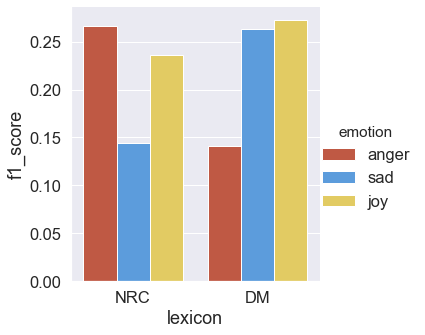

In [67]:
import seaborn as sns
sns.set(font_scale=1.5)
my_palette = sns.color_palette(['#D34B30','#479CF1','#F7D84E'])
sns.set_palette(palette=my_palette)

sns.catplot(x="lexicon", y="f1_score", hue="emotion", kind="bar", data=f1_df_all)